# VAE: Video Clip Encoder

In [58]:
import pickle
import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
from keras import backend as K
import tensorflow as tf
from vae_func import trainedVAE
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
#config.gpu_options.allow_growth = True
keras.backend.tensorflow_backend.set_session(tf.Session(config=config))
K.clear_session()

## Load data imgs and stack into clips

In [61]:
import os
data = np.load('hiResImg_align_64.npy')
t_embed = 6 #number of frames embedded in each clip

data = np.array([data[i:i+t_embed,:,:] for i in range(data.shape[0]-t_embed)])
print(data.shape)

(9994, 6, 64, 64, 1)


##  Build VAE
Define Parameters

In [62]:
latent_dim = 2         #Dimension of the embedding space
input_shape=data[0].shape  #(timepoints, x, y, channels, )
beta = K.variable(5e-2) #hyperparemeter controlling regularization of latent space
pix_loss = 'mse'       #consider setting to 'binary' if binarized image
weighted = 0           #option to weight clips by their variance

build the model
(*note will need to change the encoder/decoder if non-square imgs)

In [82]:
d = input_shape[1]
t = input_shape[0]

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector video clip."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class setBeta(keras.callbacks.Callback):
    """"Allows the latent regularization to increase over epochs (find good embedding then contract)"""
    def __init__(self, beta,):
        self.beta = beta
    def f(self,epoch):
        beq = 3e-2
        b0=3e-3
        return beq-(beq-b0)*.97**epoch
    def on_epoch_begin(self, epoch, logs={}):
#         K.set_value(self.beta, self.f(epoch))
        return

def network_encoder(x, latent_dim=2):
    '''build encoder'''
    x = layers.Conv3D(32, 3, activation="relu", strides=(2,2,2,), padding="same")(x)
    x = layers.Conv3D(64, 3, activation="relu", strides=(1,2,2,), padding="same")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(16, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    return z_mean, z_log_var, z


def network_decoder(x): 
    """build decoder"""
    x = layers.Dense(16, activation="relu")(x)
    x = layers.Dense(t//1 * d//2 * d//2 * 64, activation="relu")(x)
    x = layers.Reshape((t//1, d//2, d//2, 64))(x)
    x = layers.Conv3DTranspose(64, (2,3,3), activation="relu", strides=(1,2,2), padding="same")(x)
    x = layers.Conv3DTranspose(32, (2,3,3), activation="relu", strides=(1,1,1), padding="same")(x)
    
    if pix_loss == 'binary':
        decoder_outputs = layers.Conv3DTranspose(input_shape[-1], 3, activation="sigmoid", padding="same")(x) 
    elif pix_loss == 'mse':
        decoder_outputs = layers.Conv3DTranspose(input_shape[-1], 3, activation="linear", padding="same")(x)
    return decoder_outputs


#Define encoder model
encoder_input = keras.layers.Input(input_shape)
z_mean, z_log_var, z = network_encoder(encoder_input,latent_dim=latent_dim)
#encoder_samp = keras.models.Model(encoder_input, z, name='encoder_sampler')
encoder = keras.models.Model(encoder_input, z_mean, name='encoder')

#define decoder model
decoder_input = keras.layers.Input((latent_dim,))
decoder_output = network_decoder(decoder_input)
decoder = keras.models.Model(decoder_input,decoder_output, name='decoder')
reconstruction = decoder(z)

def custom_loss_wrapper(z_mean=z_mean,z_log_var=z_log_var):
    """"Returns the loss function for keras training"""
    
    def loss(y_true, y_pred):
        if weighted:
            w = K.sqrt(tf.reduce_mean(K.var(y_true,axis=0)))
        else:
            w = K.variable(1)
        if pix_loss == 'binary':
            reconstruction_loss = tf.reduce_mean(
                        keras.losses.binary_crossentropy(y_true,y_pred)
                    )            
            reconstruction_loss *= d**2
        elif pix_loss == 'mse':
            reconstruction_loss = tf.reduce_mean(keras.losses.mean_squared_error(y_true,y_pred,))
            reconstruction_loss *= d**2
        
        kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
        kl_loss = tf.reduce_mean(kl_loss)
        kl_loss *= -beta
        return w * (reconstruction_loss + kl_loss)
    return loss

def reconstruction_loss(y_true, y_pred):
    if weighted:
        w = K.sqrt(tf.reduce_mean(K.var(y_true,axis=0)))
    else:
        w = K.variable(1)
            
    if pix_loss == 'binary':
        reconstruction_loss = tf.reduce_mean(
                    keras.losses.binary_crossentropy(y_true,y_pred)
                )           
        reconstruction_loss *= d**2
    elif pix_loss == 'mse':
        reconstruction_loss = tf.reduce_mean(keras.losses.mean_squared_error(y_true,y_pred,))
        reconstruction_loss *= d**2
    return w * reconstruction_loss

def KL_loss_wrapper(z_mean=z_mean,z_log_var=z_log_var):
    def KLloss(y_true, y_pred):
        if weighted:
            w = K.sqrt(tf.reduce_mean(K.var(y_true,axis=0)))
        else:
            w = K.variable(1)
        kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
        kl_loss = tf.reduce_mean(kl_loss)
        kl_loss *= -beta
        return w * kl_loss
    return KLloss

model = keras.models.Model(encoder_input,reconstruction)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss=custom_loss_wrapper(z_mean,z_log_var),
              metrics=[reconstruction_loss,
                       KL_loss_wrapper(z_mean,z_log_var)])

Train on 9494 samples, validate on 500 samples
Epoch 1/10
9494/9494 [==============================] - 30s 3ms/step - loss: 3.9561 - reconstruction_loss: 3.9342 - KLloss: 0.0192 - val_loss: 2.7055 - val_reconstruction_loss: 2.6339 - val_KLloss: 0.0342
Epoch 2/10
9494/9494 [==============================] - 29s 3ms/step - loss: 1.6060 - reconstruction_loss: 1.5405 - KLloss: 0.0648 - val_loss: 2.4306 - val_reconstruction_loss: 2.3555 - val_KLloss: 0.0443
Epoch 3/10
9494/9494 [==============================] - 29s 3ms/step - loss: 1.4626 - reconstruction_loss: 1.3943 - KLloss: 0.0683 - val_loss: 1.7474 - val_reconstruction_loss: 1.6795 - val_KLloss: 0.0507
Epoch 4/10
9494/9494 [==============================] - 22s 2ms/step - loss: 1.3109 - reconstruction_loss: 1.2372 - KLloss: 0.0735 - val_loss: 1.4823 - val_reconstruction_loss: 1.4195 - val_KLloss: 0.0504
Epoch 5/10
9494/9494 [==============================] - 21s 2ms/step - loss: 1.2075 - reconstruction_loss: 1.1301 - KLloss: 0.0786 - 

<IPython.core.display.Javascript object>


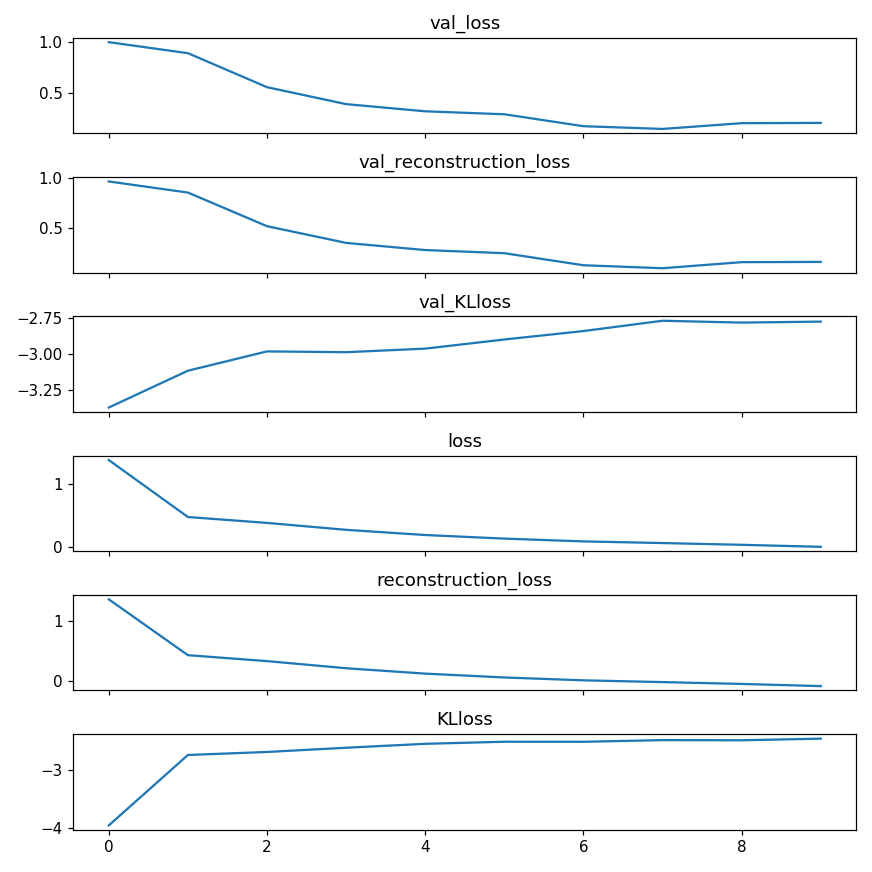

<IPython.core.display.Javascript object>


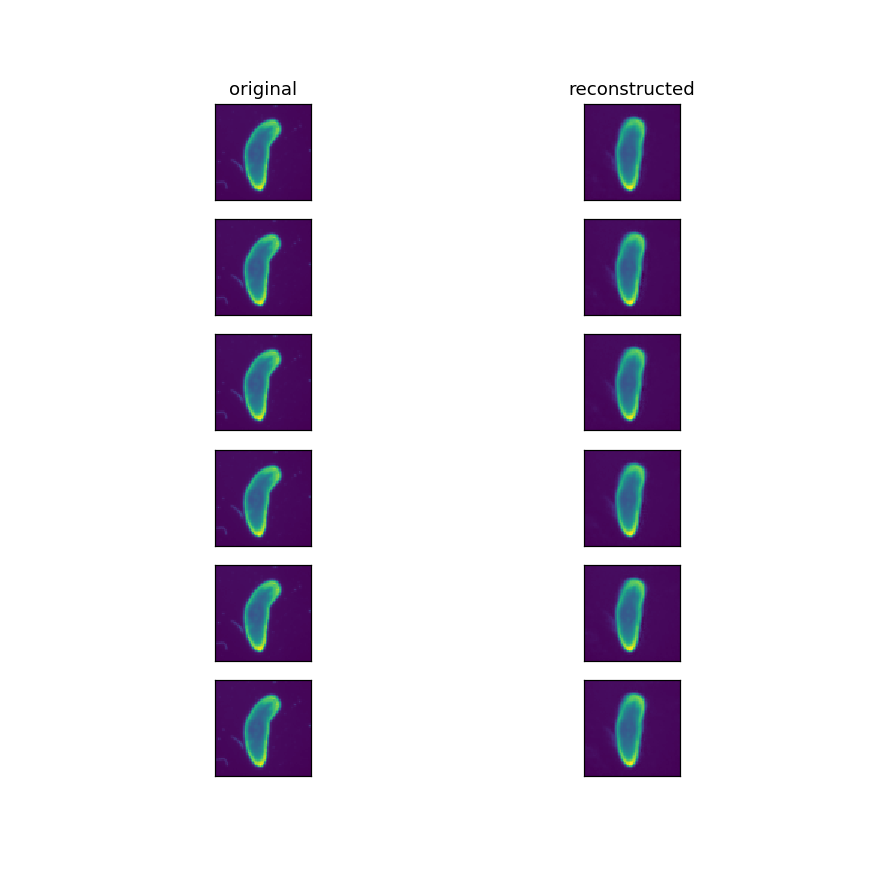

Text(0.5, 1.0, 'reconstructed')

In [87]:
history = model.fit(x=data,y=data, epochs=10, batch_size=32,
                    validation_split=.05,callbacks=[setBeta(beta)])

pred = model.predict(data[:])
latent = encoder.predict(data)
fig, ax = plt.subplots(nrows=len(history.history.keys()),sharex=True,figsize=(8,8))
for i,k in enumerate(history.history.keys()):
    ax[i].plot(np.log(history.history[k]),label=k)
    ax[i].set_title(k)
plt.tight_layout()
k=int(1900*2)
fig, ax = plt.subplots(nrows=t,ncols=2, figsize=(8,8))
for i in range(t):
    ax[i,0].imshow(data[k,i,:,:,0])
    ax[i,1].imshow(pred[k,i,:,:,0])
    ax[i,0].set_xticks([])
    ax[i,0].set_yticks([])
    ax[i,1].set_xticks([])
    ax[i,1].set_yticks([])
ax[0,0].set_title('original')
ax[0,1].set_title('reconstructed')

*** note, KL loss may increase over time due to $\beta$ schedule

## Latent Space Embedding
Display the reconstructed clips across latent space

<IPython.core.display.Javascript object>


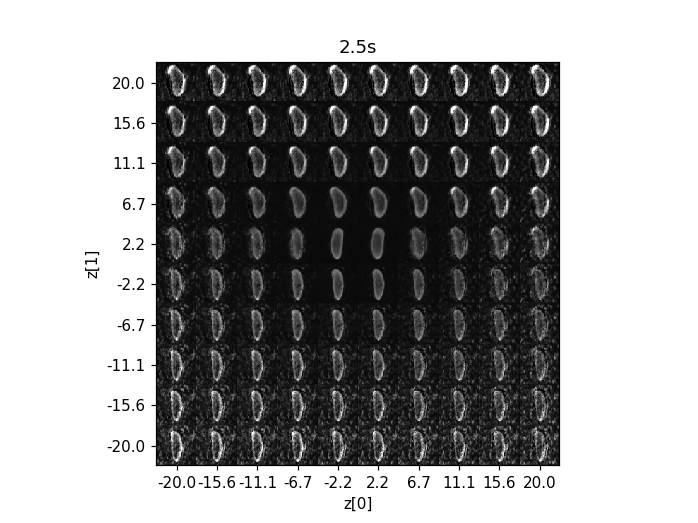

In [93]:
import matplotlib.animation as animation

n2=100
n = 10
digit_size = d
scale =20#2.0
figsize = 15


# fig = plt.figure(figsize=(8,8))
def plot_latent(encoder, decoder, ax):
    # display a n*n 2D manifold of digits
    figure = np.zeros((t,digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n) +0
    grid_y = np.linspace(-scale, scale, n)[::-1] +0

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(t,digit_size, digit_size)
            figure[:,
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    ims=[]
    for i in range(t):
        
        im = plt.imshow(figure[i], cmap="Greys_r",clim=(0,1))
        im2 = plt.title(str(i/2)+'s')
        ims.append([im,im2])
    return ims

%matplotlib notebook
#fig, ax = plt.subplots(ncols=2)
bins = np.linspace(-scale,scale,n2)
h,bx,by = np.histogram2d(latent[:,1],latent[:,0],bins=(bins,bins))
#
ims = plot_latent(encoder, decoder, ax)
ani = animation.ArtistAnimation(fig, ims, interval=500, blit=False,
                                repeat_delay=10)

# plt.show()